In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

def import_from_excel(e_file, filename):
    kinase_targets = e_file['kinase target'].tolist()
    JS_scores = e_file['JS Distance Score'].tolist()
    mu = int(filename.split('.')[0].split('_')[-1])
    return [mu, kinase_targets, JS_scores]

test_results_200 = []
test_results_700 = []

for filename in os.listdir(os.getcwd()+'/Fabian_production_run/results/'):
    f = './Fabian_production_run/results/'+str(filename)
    replicate_results = []
    if filename[0] != '.' and filename[0] != '~':
        for x in range(1,4):
            open_file = pd.read_excel(f, str(x))
            inhibitor_combination = import_from_excel(open_file, filename)
            replicate_results.append((x,inhibitor_combination))
        if replicate_results[0][1][0] == 200:
            test_results_200.append(replicate_results)
        elif replicate_results[0][1][0] == 700:
            test_results_700.append(replicate_results)
        
PKIS2_data=pd.read_excel("./Fabian_production_run/110321_clinical_inhibitors_Fabian_2005.xlsx")
all_kinase_names = list(PKIS2_data.columns.values)[7:]
        
#check to make sure we have 5 sets of results for each       
print(len(test_results_200))
print(len(test_results_700))

5
5


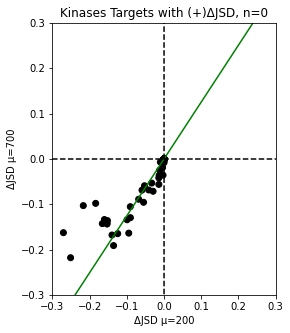

In [7]:
#check to see what the maximum inhibitor concentration # is that we should use
max_inhib_num = len(test_results_200[0])

#for each kinase, get the set of scores at i=1, i=2, i=3 etc

organized_results_200 = {}
organized_results_700 = {}

for replicate_200 in test_results_200:    #in each of the 5 test replicates
    for individual_result in replicate_200:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_200:
                organized_results_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_200[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])
            
for replicate_700 in test_results_700:    #in each of the 5 test replicates
    for individual_result in replicate_700:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_700:
                organized_results_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_700[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

#determine which condition has the maximum mean score, what the difference is from the i=1 mean score, 
#and if that difference is significant or not

x_200_scored_kinase_names = []
x_200_values = []
x_sig = []
max_200_vals = []

y_700_scored_kinase_names = []
y_700_values = []
y_sig = []
max_700_vals = []

for kinase in organized_results_200:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_200[kinase][0])
    i1_values = organized_results_200[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_200[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_200[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_200[kinase][j]
    max_200_vals.append(max_other_combination)
    #is the difference significant?
    tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
    if (pval < 0.025) and (np.mean(max_other_combination_values) > i1_mean + 0.001):
        significant = 1
    JS_score_difference = max_other_combination - i1_mean
    x_200_scored_kinase_names.append(kinase)
    x_200_values.append(JS_score_difference)
    x_sig.append(significant)
    
for kinase in organized_results_700:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_700[kinase][0])
    i1_values = organized_results_700[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_700[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_700[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_700[kinase][j]
    max_700_vals.append(max_other_combination)
    #is the difference significant?
    tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
    if (pval < 0.05) and (np.mean(max_other_combination_values) > i1_mean + 0.001):
        significant = 2
    JS_score_difference = max_other_combination - i1_mean
    y_700_scored_kinase_names.append(kinase)
    y_700_values.append(JS_score_difference)
    y_sig.append(significant)
    
#for each kinase in PKIS2, get the x_val, the y_val, the total significance

final_kinases = []
final_x = []
final_y = []
sum_sig = []

for kinase_target in all_kinase_names:
    final_kinases.append(kinase_target)
    if kinase_target in x_200_scored_kinase_names:
        index = x_200_scored_kinase_names.index(kinase_target)
        final_x.append(x_200_values[index])
        sum_sig.append(x_sig[index])
    else:
        final_x.append(0)
        sum_sig.append(0)
    if kinase_target in y_700_scored_kinase_names:
        index = y_700_scored_kinase_names.index(kinase_target)
        final_y.append(y_700_values[index])
        sum_sig[-1] = sum_sig[-1] + y_sig[index]
    else:
        final_y.append(0)

#convert significane to a different color for the points
#black = not significant
#yellow = significant for 200 (1)
#blue = significant for 700 (2)
#cyan = significant for both (3)
point_color = []
total = 0
for value in sum_sig:
    if value == 1:
        point_color.append('y')
        total+=1
    elif value == 2:
        point_color.append('b')
        total+=1
    elif value == 3:
        point_color.append('c')
        total+=1
    else:
        point_color.append('k')
       
fig = plt.figure(figsize=(4, 5))
plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
        #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.3,0.3))
plt.ylim((-0.3,0.3))
plt.xlabel('ΔJSD μ=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k--')
plt.plot(zeros,yv,'k--')

plt.show()

fig.savefig("120121_Fabian_JSD_700v200_scatterplot_newest.pdf", bbox_inches='tight',dpi=500)

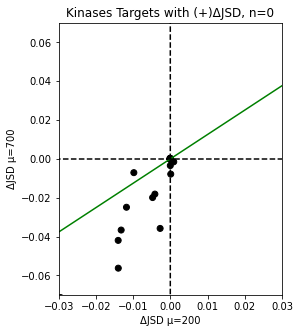

In [8]:
#replot with tighter axis

fig = plt.figure(figsize=(4, 5))
plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
        #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.03,0.03))
plt.ylim((-0.07,0.07))
plt.xlabel('ΔJSD μ=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k--')
plt.plot(zeros,yv,'k--')

plt.show()

fig.savefig("120121_Fabian_JSD_700v200_scatterplot_zoomin_newest.pdf", bbox_inches='tight',dpi=500)

In [9]:
#Who are the kinases that showed statistically significant improvement?

print('average 200 i=1 score:' + str(np.mean(mu200)))
print('average 700 i=1 score:' + str(np.mean(mu700)))

res = []
for i in range(0, len(final_kinases)):
    k = final_kinases[i]
    mu200 = final_x[i]
    mu700 = final_y[i]
    tscore = mu200+mu700
    if mu200 == 0:
        mu200 = 'N/A'
    if mu700 == 0:
        mu700 = 'N/A'
    sig = sum_sig[i]
    if sig>=1:
        res.append((tscore,k,mu200,mu700))
res = sorted(res, key=lambda x: x[0], reverse=True)
print('kinase','ΔJSD_μ=200','ΔJSD_μ=700')
counter = 1
for k in res:
    print(counter,k[1],k[2],k[3])
    counter+=1
    

average 200 i=1 score:0.7567626889861948
average 700 i=1 score:0.694602749434789
kinase ΔJSD_μ=200 ΔJSD_μ=700
